# Predicting Abundance

When working with a dataset containing many features (quantitative and qualitative) to predict a continuous variable, you have several options for model selection. Here are a few models that you can consider:

**Linear Regression**: A simple and interpretable model that assumes a linear relationship between the features and the target variable.

**Random Forest Regression**: A powerful ensemble model that can handle a mixture of feature types and capture non-linear relationships.

**Gradient Boosting Regression**: Another ensemble model that sequentially builds weak models to make accurate predictions. Algorithms like XGBoost or LightGBM can be used.

**Support Vector Regression**: A model that uses support vector machines to perform regression. It can handle both linear and non-linear relationships with proper kernel selection.

**Neural Networks**: Deep learning models can capture complex relationships between features and the target variable. They can handle both quantitative and qualitative features, but they may require more data and computational resources.

## Import Libraries
Start by importing the necessary libraries such as pandas, numpy, scikit-learn, and any other libraries required for your analysis.

In [117]:
#Libraries
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st

#Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import make_column_selector
from sklearn.compose import ColumnTransformer

# Modeling
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

## Load the Dataset
Load your dataset into a pandas DataFrame and explore its structure using methods like head(), info(), and describe().

In [3]:
# Species data
df = pd.read_csv('../data/all_species.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1949 entries, 0 to 1948
Columns: 158 entries, Datetime to Abundance (ind/m2)
dtypes: float64(153), object(5)
memory usage: 2.3+ MB


In [5]:
df.head()

,Datetime,Tide,Weather Condition,Water temperature (ºC),Zone,Supratidal/Middle Intertidal,Substrate,Chthamalus sp.,Balanus perforatus,Patella sp.,...,Callionymus lira (peixe-pau lira),Oncidiella celtica,Doriopsilla areolata (nudibrânquio),Scorpaena sp. (Rascasso),Lipophrys pholis (ad.),Diplodus cervinus,Gobiusculus flavescens,Sessile Coverage,Total Mobile Species,Abundance (ind/m2)
0,11/28/2011 10:10:00,0.6,Clear sky,16.0,D,Medium,Puddle,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,66.45,4.0,0.05
1,11/28/2011 10:25:00,0.6,Clear sky,16.0,D,Medium,Rock,8.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,75.10,2.0,0.10
2,11/28/2011 10:40:00,0.6,Clear sky,16.0,D,Medium,Rock,25.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67.20,1.0,0.00
3,11/28/2011 11:00:00,0.6,Clear sky,16.0,E,Medium,Rock,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,2.0,0.20
4,11/28/2011 11:15:00,0.6,Clear sky,16.0,E,Medium,Rock,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,48.25,0.0,0.00


In [6]:
variables = ['Tide', 'Water temperature (ºC)', 'Sessile Coverage', 'Total Mobile Species','Abundance (ind/m2)']
df[variables].describe()

,Tide,Water temperature (ºC),Sessile Coverage,Total Mobile Species,Abundance (ind/m2)
count,1949.000000,1949.000000,1949.000000,1945.000000,1949.000000
mean,0.728086,16.833299,52.866239,3.900771,0.210236
std,0.180290,2.255414,34.441960,12.853757,0.646289
min,0.300000,11.000000,0.000000,0.000000,0.000000
25%,0.600000,15.000000,21.050000,0.000000,0.000000
50%,0.700000,17.000000,57.000000,0.000000,0.000000
75%,0.900000,19.000000,85.100000,3.000000,0.150000
max,1.400000,22.000000,123.500000,254.000000,12.700000


**Initial Observations**
- `Tide` has a nearly equal mean and median with a majority of values spread within 2 (TODO: How was tide measured?), indicating a possible normal distribution.
- `Water temperature (ºC)` may have a similar distribution to `Tide`. Are observed min and max values related for these features due to an event?
- `Sessile Coverage` may need to be plotted to confirm if the distribution is normal. Is there a time factor, like seasonality?
- `Total Mobile Species` and related field `Abundance(ind/m2)` has a relatively large range of sample values. Double check that thes values appear to be correlated.

**Note**: This evaluation is not only to determine the shape of the distribution, as all numeric columns are transformed by removing the mean value of each feature, then scaling it using SciKit Learn's Preprocessing library.


## Data Preprocessing
Perform any necessary data preprocessing steps, such as handling missing values and splitting the data into training and testing sets. Note that additional processing is done within the pipeline.

### Handle mising values

In [7]:
df['Datetime'] = df['Datetime'].astype('datetime64[ns]')

In [8]:
# Check for missing values in each column
missing_values = df.isnull().sum()
print(missing_values)

Datetime                  0
Tide                      0
Weather Condition         0
Water temperature (ºC)    0
Zone                      0
                         ..
Diplodus cervinus         0
Gobiusculus flavescens    0
Sessile Coverage          0
Total Mobile Species      4
Abundance (ind/m2)        0
Length: 158, dtype: int64


In [9]:
# Fill missing values
# filling missing values in numeric columns with mean
numeric_columns = df.select_dtypes(include='number').columns
df[numeric_columns] = df[numeric_columns].fillna(df[numeric_columns].mean())

# filling missing values in categorical columns with mode
categorical_columns = df.iloc[:,1:].select_dtypes(include='object').columns
df[categorical_columns] = df[categorical_columns].fillna(df[categorical_columns].mode().iloc[0])

categorical_columns

Index(['Weather Condition', 'Zone', 'Supratidal/Middle Intertidal',
       'Substrate'],
      dtype='object')

In [10]:
# Verify if missing values have been handled
missing_values_after_handling = df.isnull().sum()
print(missing_values_after_handling)

Datetime                  0
Tide                      0
Weather Condition         0
Water temperature (ºC)    0
Zone                      0
                         ..
Diplodus cervinus         0
Gobiusculus flavescens    0
Sessile Coverage          0
Total Mobile Species      0
Abundance (ind/m2)        0
Length: 158, dtype: int64


# EDA

/Users/franknovak/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


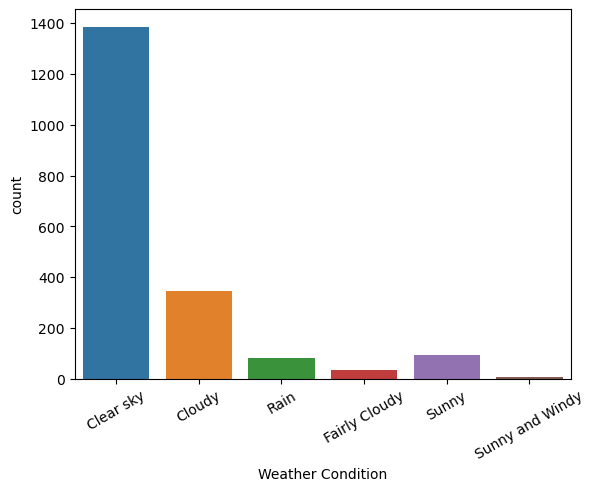

In [103]:
g = sns.countplot(df["Weather Condition"])
g.set_xticklabels(labels=df["Weather Condition"].unique(), rotation=30);

/Users/franknovak/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Zone', ylabel='count'>

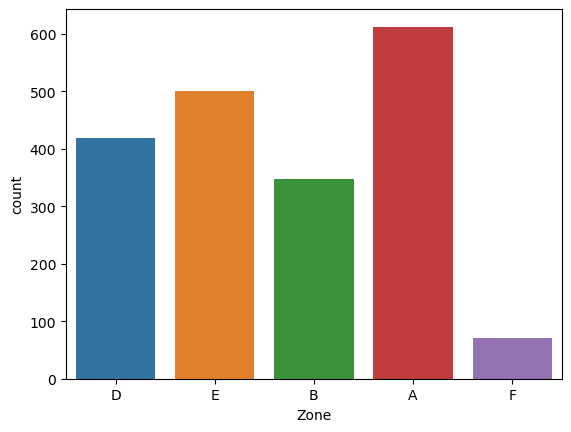

In [104]:
sns.countplot(df["Zone"])

### Variables
- Tide does not have a cyclical or seasonal pattern in the graph
    - The measure in meters of the low tide. For more information see: https://oceanservice.noaa.gov/education/tutorial_tides/tides01_intro.html
- Sea temperature has a seaonsonal patter, is it stationary? Augmented Dickey-Fuller test (ADF Test)
- Sessile Coverage needs more exploration in its patterm
    - total % covered of the sample with sessile species
- Total / Abundence droppped off at the end of 2016, what happened?
    - How many individuals of mobile species studied were found in the sample per m2


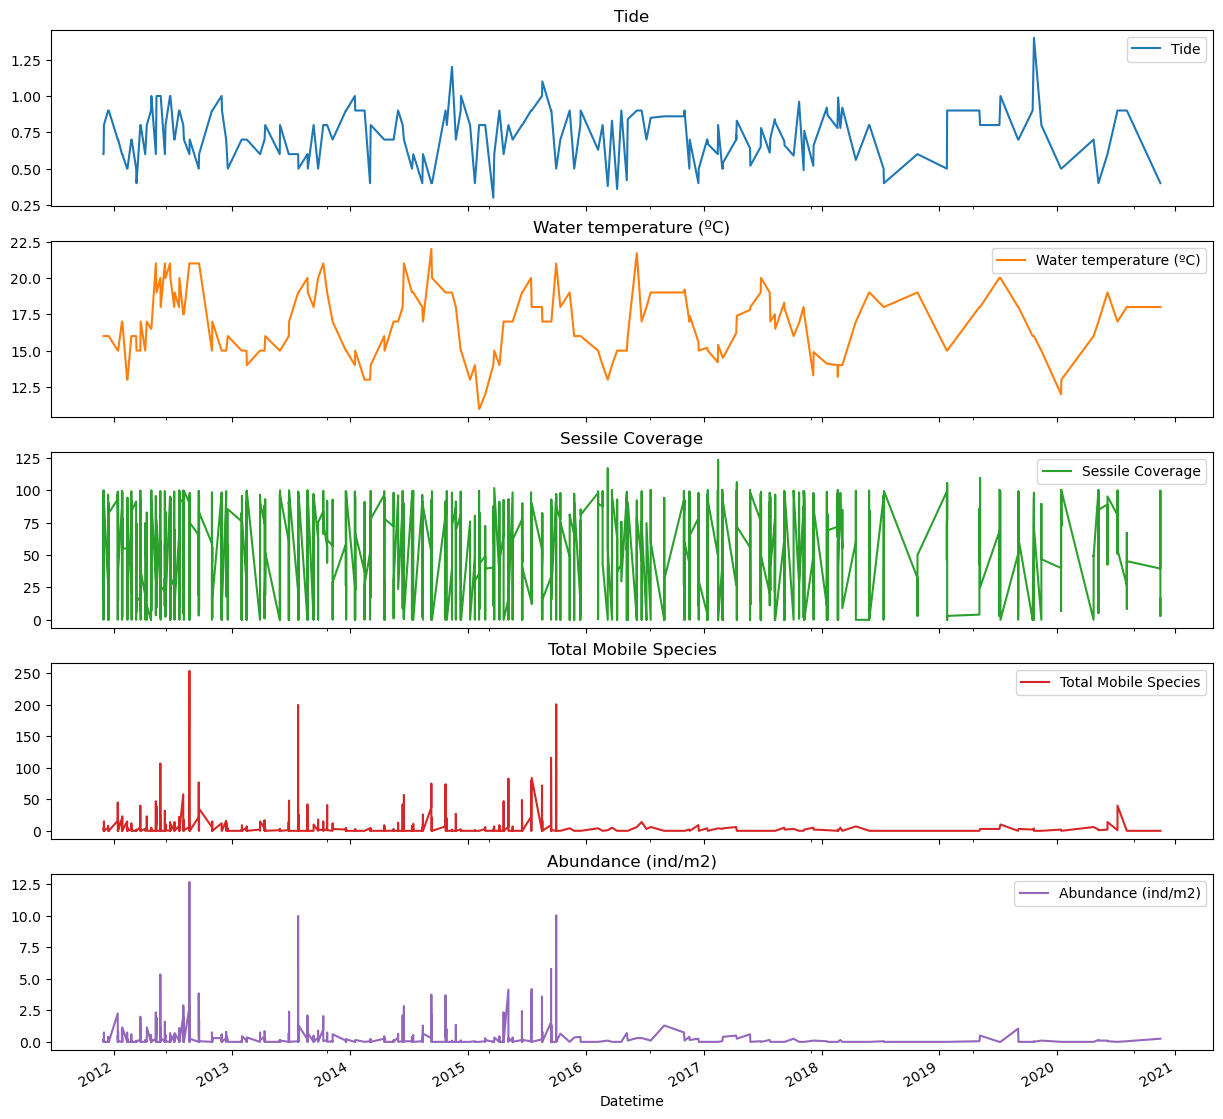

In [27]:
df_dt = df.set_index('Datetime')
df_dt[variables].plot(subplots=True,figsize = (15,15),title=variables);

### Invasive Species Overtime
- Asparagopsis armata has an increase in coverage after the drop in abundence in 2016, is this related?
- Cladophora sp. most aggressive invasive species 
    - 'Where Cladophora becomes a pest is generally where special circumstances cause such drastic overgrowth that algal blooms develop and form floating mats. Typical examples include where hypertrophication or high mortality of rival organisms produce high concentrations of dissolved phosphorus. Extensive floating mats prevent circulation that is necessary for the aeration of deeper water and, by blocking the light, they kill photosynthesising organisms growing beneath. The mats interfere with the fishing industry by clogging nets and preventing the use of lines. Where they wash ashore the masses of rotting material reduce shoreline property values along water bodies such as the Great Lakes in the United States.[4]'

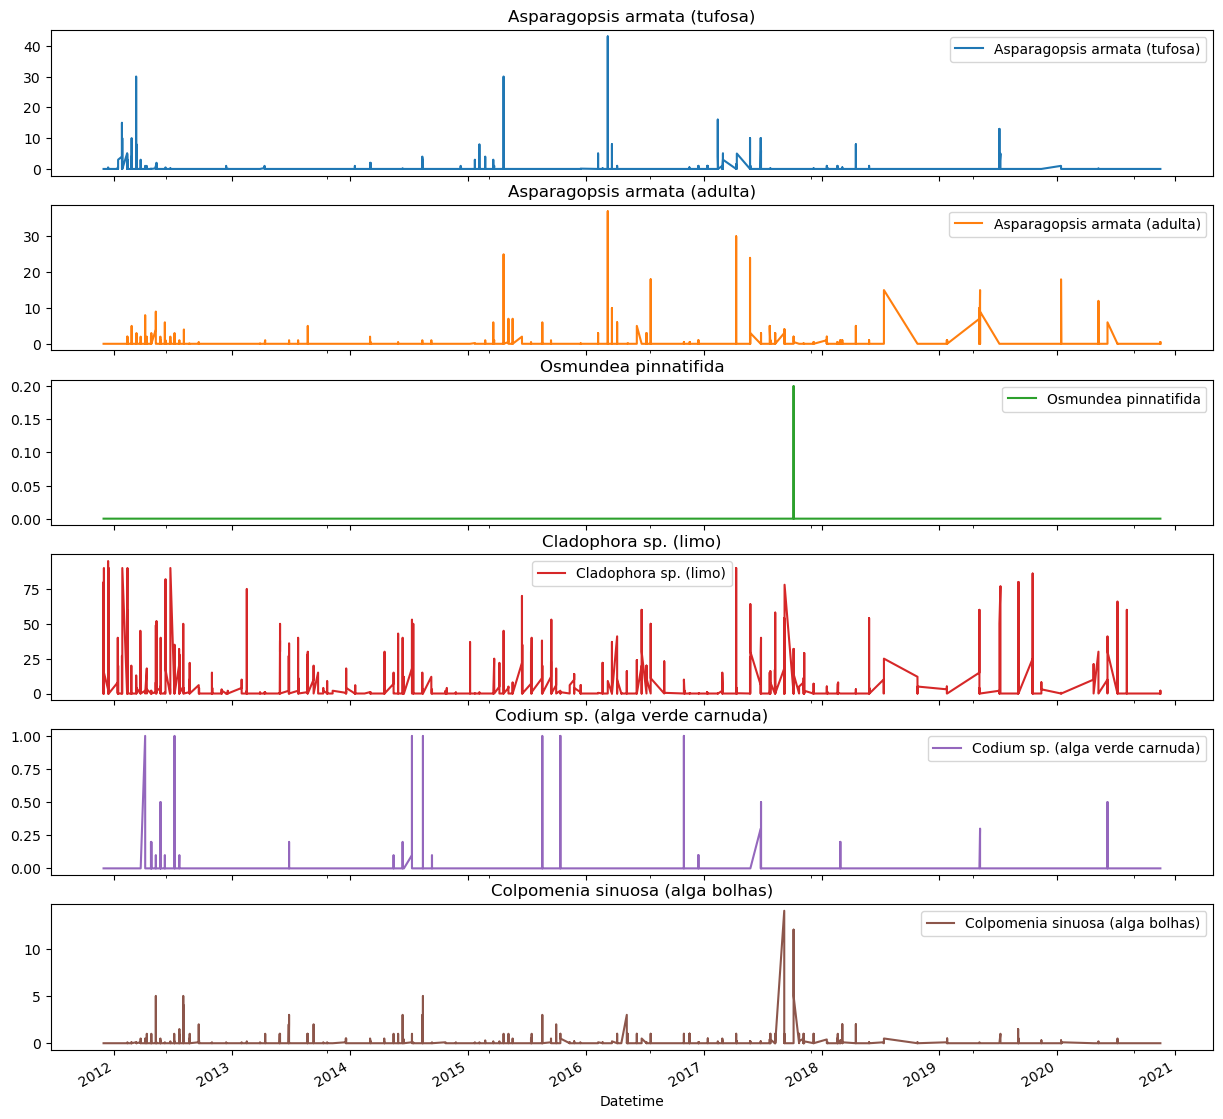

In [62]:
invasive = ['Asparagopsis armata (tufosa)',
            'Asparagopsis armata (adulta)', 
            'Osmundea pinnatifida',
            'Cladophora sp. (limo)',
            'Codium sp. (alga verde carnuda)',
            'Colpomenia sinuosa (alga bolhas)']

df_dt[invasive].plot(subplots=True,figsize=(15,15),title=invasive);

In [ ]:
df_dt.groupby(by='Weather Condition')['Abundance (ind/m2)'].agg(np.mean).sort_values().plot()
df_dt.groupby(by='Cladophora sp. (limo)')[variables].agg(np.mean).plot()

In [ ]:
month_group = df_dt.groupby(pd.Grouper(freq='M'))
month_ts = month_group.agg({'Tide': np.mean,
      'Weather Condition':lambda x: st.mode(x,keepdims=False)[0],
      'Water temperature (ºC)':np.mean,
      'Supratidal/Middle Intertidal':lambda x: st.mode(x,keepdims=False)[0],
      'Substrate':lambda x: st.mode(x,keepdims=False)[0],
      'Abundance (ind/m2)':np.mean})

month_ts.plot()

<AxesSubplot:xlabel='Datetime'>

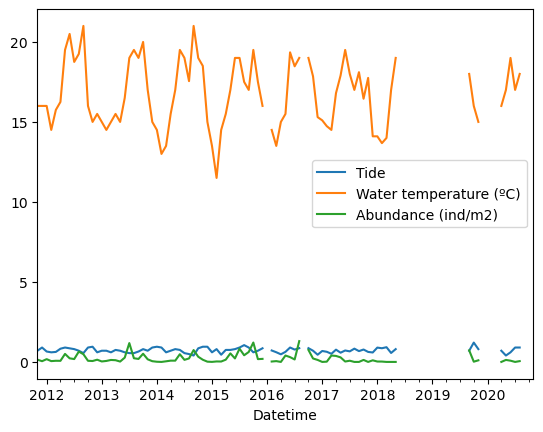

### Train/Test split

In [10]:
X = df.drop(columns=['Abundance (ind/m2)', 'Datetime'])
y = df['Abundance (ind/m2)']

print(X.shape)
print(y.shape)

(1949, 156)
(1949,)


In [11]:
# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Model Training
Train the selected model(s) on the training data using the fit() method.

### Building a Pipeline 
**Step : Data Preprocessing**

Encoding categorical variables, scaling numerical features, and accounting for datetime structure with attention to month and impact of Hercules storm that required dock maintenance from Jan 2014 to Summer 2016. 

**Step : Feature Selection/Dimensionality Reduction**

Apply dimensionality reduction techniques like Principal Component Analysis (PCA) or other methods such as Feature Importance, Recursive Feature Elimination, or SelectKBest to reduce the number of features.

**Step : Model Selection**

Choose the appropriate model(s) based on your problem and dataset characteristics. Provide a brief explanation of each model and why you selected it.

Handling datetime for input into model
```python
def extract_temporal_features(x):
    """Return true if x is in the range [start, end]"""
    return start <= x or x <= end
    
extract_temporal_features('2014-01-01', '2016-08-31', X['Datetime'][0])
    ('month', FunctionTransformer(lambda x: x.dt.month.values.reshape(-1, 1)), ['Datetime']),  # Custom transformer for datetime column
    ('temporal', FunctionTransformer(lambda x: extract_temporal_features(x)), ['Datetime']),  # Custom transformer for temporal features
```

In [12]:
# Define the transformations for different column types
transformers = [
    ('numerical', StandardScaler(), make_column_selector(dtype_include=np.number)),  # StandardScaler for numerical columns
    ('categorical', OneHotEncoder(handle_unknown='ignore'), make_column_selector(dtype_include=object)),  # OneHotEncoder for categorical columns
    ('pca', PCA(n_components=2), make_column_selector(dtype_include=np.number))  # PCA for numerical features
]

# Create the column transformer
preprocessor = ColumnTransformer(transformers)

# Create the pipeline with preprocessor and classifier
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LinearRegression())
])

In [13]:
# Fit the pipeline on the data
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical', StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x12ba10ed0>),
                                                 ('categorical',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x139009190>),
                                                 ('pca', PCA(n_components=2),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x139008e90>)])),
                ('classifier', LinearRegression())])

In [14]:
# Make predictions on the test data
y_pred = pipeline.predict(X_test)

### Model Evaluation
Evaluate the trained models using appropriate metrics such as mean squared error (MSE), mean absolute error (MAE), R-squared, or others suitable for regression tasks. Compare the performance of different models.

### Hyperparameter Tuning
If necessary, perform hyperparameter tuning using techniques like grid search or randomized search to optimize the model performance.

### Final Model and Predictions
Select the best-performing model based on evaluation metrics, retrain it on the full training data, and make predictions on the test set. Evaluate the final model's performance and interpret the results.

### Conclusion
Summarize your findings, discuss any insights gained from the analysis, and suggest future steps for improvement if applicable.